In [ ]:
import csv
import numpy as np
from pathlib import Path
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess, json, tqdm, os
import torch, torchaudio, torchvision.transforms as T
import random
from typing   import List, Tuple

from torchcodec.decoders import VideoDecoder              # torchcodec 0.3.0
from transformers        import AutoModel, AutoProcessor   # transformers 4.x

If you have access to the cloned github/video data. Run this as a sanity check that you have access to the vids

In [2]:
# file = "image-data/9s4baJE29mP6-0Nk-KJRoS7TV34.jpg"
def read_csv(path):
    with open (path) as rf:
        reader = csv.DictReader(rf)
        rows = []
        # print(reader)
        row_lens = dict()
        for row in reader:
            rows.append(row)
            # print(row)
            if not ((len(row)) in row_lens.keys()):
                row_lens[len(row)] = 1
            else:
                row_lens[len(row)] += 1
        return rows
    csv.DictReader() 
    
def check_all_names_found (media_file, metadata_file):
    imgFileList = os.listdir(media_file)
    csv_rows = read_csv(metadata_file)[1::]
    found_count = 0
    not_found_count = 0
    found_files = []
    not_found = []
    for r in csv_rows:
        # print(r)
        name = r["Filename"]
        if (name in imgFileList):
            found_count += 1
            found_files.append(name)
            # if ()
        else:
            not_found_count += 1
            not_found.append(name)
        # print(r["Filename"])
    # print(csv_rows)
    print(f"FOUND: {found_count}")
    print(f"NOT FOUND #: {not_found_count}")
    print(f"NOT FOUND #: {not_found}")
    return np.array(found_files)

def load_vid(file):
    file = "video-data/" + file
    cap = cv2.VideoCapture(file)
    #get all of the dimensions of the video for the numpy array
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    
    rgb_count = np.zeros((frame_count, height, width, 3), dtype = np.uint8)
    
    if not cap.isOpened():
        raise IOError("Cannot open vid")
    for i in tqdm(range(frame_count)):
        ret, frame = cap.read()
    
        # print(f"Frame length of vid: {frame_count}")
        if not ret:
            cap.release()
            return
        
        rgb_count[i] = frame[..., ::-1] ## cv2 tyrants used bgr instead of rgb, need to invert it 
    
    height, width = frame.shape[:2]
    print(f"height: {height}")
    print(f"width: {width}")
    return rgb_count


def load_vid_list(files, label):
    num = len(files)
    label_col = np.full(num, label)
    
    for i in tqdm(range(num)):
        cap = cv2.VideoCapture("video-data/" + files[i])
        if not cap.isOpened():
            raise IOError("Cannot open vid")
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        
        rgb_count = np.zeros((frame_count, height, width, 3), dtype = np.uint8)
        
        for j in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                print(f"video that failed: video-data/{files[i]}, skipping now")
                i += 1
                break
            rgb_count[j] = frame[..., ::-1]
        
    
    return rgb_count




In [3]:
clean_vids = check_all_names_found("video-data/", "video-metadata-publish.csv")

def clear_unknowns(clean_vids, metadata_file):
    csv_rows = read_csv(metadata_file)
    bof = {"Real": [], "Fake": []}
    for row in csv_rows:
        vL = row["Video Ground Truth"]
        aL = row["Audio Ground Truth"]
        if vL == "Real" and aL == "Real":
            bof["Real"].append(row["Filename"])
        elif vL == "Fake" and aL == "Fake":
            bof["Fake"].append(row["Filename"])
    return bof

FOUND: 2035
NOT FOUND #: 0
NOT FOUND #: []


In [4]:
clean_vids = check_all_names_found("video-data", "video-metadata-publish.csv")
bof = clear_unknowns(clean_vids, "video-metadata-publish.csv")
print(bof)
print(f"Len of real_real: {len(bof["Real"])}")
print(f"Len of fake_fake: {len(bof["Fake"])}")

FOUND: 2035
NOT FOUND #: 0
NOT FOUND #: []
{'Real': ['HICemuEclIn-ZDbqZVUULNCfNMI.mp4', 'kAaNHcuBnFPnxe4tspbxc_muFTw.mp4', '7QkcRIbGeqPx-3lRLNVEoF3Z9MM.mp4', 'rN7AySTzGxCHYrDYJcrqqN9ybNc.mp4', 'YBy7OnWBQ3GOQzm53dEEQv3_YBk.mp4', 'nefJI_4TbHarNctRfXP_pXxf4fg.mp4', '5lFghVsgAMh2mS_6lW4dNxa3Ma0.mp4', '_jB8v1mKu-G-YtCcsbCDz-Xqy7I.mp4', 'ZhGDGjAEcmCeKMaL7n2EHc4QtO8.mp4', 'C2itTABNRmzZt3NMWX5xtgV2E-g.mp4', 'JcazzdNzkDMktnDR6iORAoJzRNs.mp4', 'KNRJMAZi9TCdajnupiEMw4vDyl0.mp4', 'tMZRLQlh4tgT49AIODi_H44tHTA.mp4', 'S-M6eZeqaT8FOPEgHpUeboW4DIc.mp4', 'DtE_ZtU_z3fU4DSIvU4h9COtvno.mp4', 'lwf0nbH97hWa6zRYnkyRtIvynzQ.mp4', '5_sVFeQ4JyHtu2bIysyApXAtDyI.mp4', 'qtusd7VLnWcHTJtQjmVjTednP3c.mp4', '_-v4jJibKTSv-slQIrt8DfnwrRU.mp4', 'ylUxctRpgu_Aqya7Mg268MLaf5M.mp4', 'CV8UPfKVejNrpp5mgEcJQibabCw.mp4', '-wHhS6r-xuXnfOId95KMz5YTuJ4.mp4', 'fnGAuF4EzmmT1UhGMMHv2MwrOW8.mp4', 'hGah7PGiNDWpPJFWDGizAas1hzU.mp4', 'jBj3uM9aJU_N2Q6Lafb3BJS_S6g.mp4', 'TVPSrhfYU9_VIS47bAehJggz83c.mp4', 'kiuaxEn9qpF8h4WbN064opCsPN4.mp4', '1

Make a manifest csv to share what videos we will use for the dataset.


In [5]:

base_dir   = Path("video-data/")
real_files = bof["Real"]               
fake_files = bof["Fake"]

def make_manifest(names: List, label: int):
    full_paths: List = []
    for file in names:
        full_path = base_dir / file  
        full_paths.append(full_path.as_posix())
    df = pd.DataFrame({
        "path":  full_paths,
        "label": label
    })
    return df

manifest = pd.concat([make_manifest(real_files, 0), make_manifest(fake_files, 1)], ignore_index=True)

def video_duration_tc(path):
    """
    Returns clip duration by seconds (roughly).
    """
    vd  = VideoDecoder(path)
    meta = vd.metadata 
    # print(meta)

    if (not (meta.average_fps is None)) and meta.average_fps > 0:
        return len(vd) / meta.average_fps

    # 2) header already stores duration? (not always present)
    if meta.duration is not None:
        return meta.duration

    # 3) as a last resort, decode one packet to query its PTS
    raise RuntimeError("no duration information in header")

# ---------------------------------------------------------------------
# 3.  Enrich manifest with duration & drop unreadable clips
# ---------------------------------------------------------------------
durations, bad_indices = [], []

# any time you see tqdm its just to make the progress bar, dont worry about it
for idx, row in tqdm.tqdm(manifest.iterrows(), total=len(manifest)):
    try:
        durations.append(video_duration_tc(row["path"]))
    except Exception as e:
        print(e)
        durations.append(np.nan)
        bad_indices.append(idx)
        print(f"BAD VIDEO {row['path']} unreadable erorr is: {e}")
    # print("adding")
manifest["duration_s"] = durations

if bad_indices:
    manifest.drop(index=bad_indices, inplace=True)
    print(f"dropped {len(bad_indices)} because they couldnt be opend")

if not manifest.empty:
    manifest.to_csv("manifest.csv", index=False)

    #-------Some videos are way too long, need to remove outliers-----------------------------------------------------
    df = pd.read_csv("manifest.csv")   # or "manifest.csv"

    dur = df["duration_s"].to_numpy()

    print(f"MEAN: {dur.mean():.2f} s")
    print(f"MEDIAN: {np.median(dur):.2f} s")
    print(f"Q1: {np.quantile(dur, .25):.2f} s")
    print(f"Q3: {np.quantile(dur, .75):.2f} s")
    Q50 = np.quantile(dur, .50) # median lol
    Q75 = np.quantile(dur, .75)
    Q95 = np.quantile(dur, .95)
    Q25 = np.quantile(dur, .25)
    print(f"Q.95: {Q95:.2f} s")
    print(f"MAX vid length : {dur.max():.2f} s")


    before = len(df)
    # df = df[df["duration_s"] <= Q95].reset_index(drop=True) If I wanted to
    df = df[df["duration_s"] <= Q75].reset_index(drop=True) # drop the ones that have about Q threshold (pruning super long vids)
    after  = len(df)

    df.to_csv("manifest_pruned_outliers.csv", index=False)
    print("Pruned videos that are outliers/too long")
    print(f"({after}/{before} remain)")
    print("Filtered manifest ➜ manifest_pruned_outliers.csv")
else:
    print("Manifest is empty after dropping bad videos. Cannot calculate statistics or prune.")

100%|██████████| 424/424 [00:04<00:00, 89.92it/s] 

MEAN: 90.70 s
MEDIAN: 43.37 s
Q1: 21.64 s
Q3: 75.23 s
Q.95: 250.03 s
MAX vid length : 5632.87 s
Pruned videos that are outliers/too long
(318/424 remain)
Filtered manifest ➜ manifest_pruned_outliers.csv


Make the models

In [ ]:
# read rgb vals for a video and store them in a tensor
_img_tx = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ConvertImageDtype(torch.float32),  # → [0,1]
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) # → recenetering [-1, 1]
])

def read_frames(path, fps: int = 2):
    """
    Decode `path` with torchcodec.VideoDecoder and return a tensor of
    shape (T, 3, 224, 224) normalised to [-1,1].
    """
    vr = VideoDecoder(path, dimension_order="NHWC") # each is (H,W,C)

    src_fps = (
        vr.metadata.average_fps
        or vr.metadata.average_fps_from_header
        or 30.0   # fall back in case nothing else is true
    )
    step = max(int(round(src_fps / fps)), 1) ## make the parameter fps super low if you want to increase video speed, lose data from this though

    frames = []
    for f in vr[::step]: # move through video in our step size
        if isinstance(f, np.ndarray):
            f = torch.from_numpy(f) #converts numpys to tensor
        frames.append(_img_tx(f.permute(2, 0, 1))) # reorder  to C,H,W
    return torch.stack(frames)       


#Audio section---------------------------

# helper to use torchaudio if it works for the vid, if not use ffmpeg
def _load_audio_any(path, sr: int = 16_000, mono: bool = True):
    try:
        wav, sr0 = torchaudio.load(path)          # tries 'soundfile' backend
        if sr0 != sr:
            wav = torchaudio.functional.resample(wav, sr0, sr)
        if mono and wav.shape[0] > 1:
            wav = wav.mean(0, keepdim=True)
        return wav, sr
    except Exception:
        # ffmpeg fallback 
        cmd = [
            "ffmpeg", "-i", str(path),
            "-f", "f32le", "-ac", "1" if mono else "2",
            "-ar", str(sr), "-"
        ]
        pcm = subprocess.check_output(cmd, stderr=subprocess.DEVNULL)
        wav = torch.frombuffer(pcm, dtype=torch.float32)
        wav = wav.view(-1) if mono else wav.view(-1, 2).t()
        return wav.unsqueeze(0), sr                # (1,N), sr

# 3.2 wav2vec2 model & processor (loaded once)
wav2vec = AutoModel.from_pretrained("facebook/wav2vec2-base").eval() # pre-trained voice recognition model. Seems to be a standard
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")

@torch.inference_mode()
def read_audio_embed(path, target_T, sr: int = 16_000) -> torch.Tensor:
    """
    Return a (T,768) feature sequence aligned to the number of video frames.
    If audio decoding fails, a zero-tensor of the right shape is returned.
    """
    try:
        wav, _ = _load_audio_any(path, sr=sr, mono=True)   # (1,N)
        feats  = wav2vec(**processor(wav.squeeze(), sampling_rate=sr, return_tensors="pt")).last_hidden_state.squeeze(0)            # (N',768)
    except Exception as e:
        print("audio failed, putting 0's in its place") # This shoudlnt happen anymore now that I filtered them out
        feats = torch.zeros(target_T, 768)
        return feats

    # temporal alignment to video: linear index sampling
    idx = torch.linspace(0, feats.size(0)-1, target_T).round().long()
    return feats[idx]  # (T,768)


# 50% cross modal masks like the report says we'll do
def make_masks(T, p = .5):
    n = int(T * p)
    perm = torch.randperm(T)
    vm = torch.zeros(T, dtype=torch.bool)
    vm[perm[:n]] = True         # mask these visual slices
    am = ~vm                    # audio is masked exactly when visual isn't
    return vm, am


#Dataset wrapper
class AVDeepfakeDataset(torch.utils.data.Dataset):
    def __init__(self, csv, fps: int = 2): #default fps if none is passed in
        self.df  = pd.read_csv(csv)
        self.fps = fps
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        path  = self.df.at[idx, "path"]
        label = self.df.at[idx, "label"]
        frames = read_frames(path, fps=self.fps)
        audio  = read_audio_embed(path, frames.size(0))
        vmask, amask = make_masks(frames.size(0))
        return frames, audio, vmask, amask, label


I ran smth to find these and print them but it took 30+ mins to run on like 200 vids so I'm leaving it out of this code

In [7]:
audios_dont_load = ["video-data/fZ09ZAlhUdYHAu60Cufv1x2y20M.mp4", "video-data/sNJIBQDVLVDPmp1J28pmG5dmuD8.mp4","video-data/F3dz0Dfm3Se6NN9QbL9h-HaHZSY.mp4",
"video-data/uUIKWQ9REZjhJgPagpiAbpUfqkI.mp4","video-data/YfX9oF_Fka8ITOhlO0Kh8rz9T60.mp4","video-data/oesaw0deyLmtIflYANhgy8RL0qY.mp4",
"video-data/KewDIqJQ-jubya1H-mOUBn1SMAg.mp4", "video-data/JXKMuwxTdJtnprXysiSjDiLlywE.mp4"]

# prunedf = pd.read_csv("manifest_pruned_outliers.csv")
# # print(prunedf)
# print(prunedf["path"])

prunedf = pd.read_csv("manifest_pruned_outliers.csv")
print(len(audios_dont_load))
print(len(prunedf))

# keep every row **whose path is NOT in** audios_dont_load
prunedf = prunedf[~prunedf["path"].isin(audios_dont_load)]

print("Rows left :", len(prunedf))
prunedf.to_csv("final_filtered_manifest.csv", index=False)

8
318
Rows left : 310


Encoding video features with resnet50 pretrained and store them so you all are able to read the features

In [8]:
from pathlib import Path
import torch, tqdm
from torchvision.models import resnet50, ResNet50_Weights

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using", device)

cnn = resnet50(weights=ResNet50_Weights.DEFAULT).to(device).eval()
feat_extractor = torch.nn.Sequential(*(list(cnn.children())[:-1]))

def rgb2feat(frames):
    with torch.inference_mode():
        f = feat_extractor(frames.to(device))
        return f.squeeze(-1).squeeze(-1).cpu()


ds = AVDeepfakeDataset("stored_features.csv", fps=2) #higher fps means more data, you can edit this
out = Path("feature_cache")
out.mkdir(exist_ok=True)

for i in tqdm.tqdm(range(len(ds)), desc="export"):
    frames, audio, vmask, amask, y = ds[i]

    key = Path(ds.df.at[i, "path"]).stem
    v_feat = rgb2feat(frames)  # (T,2048)
    a_feat = audio  # already (T,768)

    torch.save(
        {
            "vision": v_feat.half(),      # float16 to halve the size
            "audio" : a_feat.half(),
            "vmask" : vmask,
            "amask" : amask,
            "label" : y
        }, out / f"{key}.pt" # stored in feature_cache folder
    )

Using cuda


export: 100%|██████████| 78/78 [02:04<00:00,  1.60s/it]


In [9]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch

class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, feat_dir):
        self.paths = sorted(Path(feat_dir).glob("*.pt"))
    def __len__(self): 
        return len(self.paths)
    def __getitem__(self, idx):
        pkg = torch.load(self.paths[idx], map_location="cpu", weights_only=False)
        
        return pkg["vision"], pkg["audio"], pkg["vmask"], pkg["amask"], int(pkg["label"])

loader = torch.utils.data.DataLoader(FeatureDataset("feature_cache"),
                            batch_size=32, shuffle=True)

def collate_pad(batch):
    v_list, a_list, vm_list, am_list, y_list = zip(*batch)

    # --- pad features -------------------------------------------------
    v_pad = pad_sequence(v_list, batch_first=True)
    a_pad = pad_sequence(a_list, batch_first=True)

    # --- create padding mask (True where we inserted padding) ---------
    lengths = torch.tensor([x.size(0) for x in v_list])
    T_max   = v_pad.size(1)
    pad_msk = torch.arange(T_max)[None, :] >= lengths[:, None]   # (B,T_max)

    # pad+OR with existing modality masks
    vm_pad = pad_sequence(vm_list, batch_first=True) | pad_msk
    am_pad = pad_sequence(am_list, batch_first=True) | pad_msk

    labels = torch.tensor(y_list)

    return v_pad, a_pad, vm_pad, am_pad, labels


# ------------------------------------------------------------------
# Loader that can be used wiht the model (given that you have the "feature_cache" folder downlaoded and in the project)
ds = FeatureDataset("feature_cache")
loader = DataLoader(
    ds,
    batch_size   = 4,
    shuffle      = True,
    num_workers  = 0,
    collate_fn   = collate_pad,
    pin_memory   = False  # no CUDA 
)

#load a batch's dims for testing 
v_b, a_b, vm_b, am_b, y_b = next(iter(loader))
print("vision :", v_b.shape)   # (B, T_max, 2048)
print("audio  :", a_b.shape)   # (B, T_max, 768)
print("video_mask  :", vm_b.shape)
print("audio_mask :", am_b.shape)
print("labels :", y_b)

vision : torch.Size([4, 32, 2048])
audio  : torch.Size([4, 32, 768])
video_mask  : torch.Size([4, 32])
audio_mask : torch.Size([4, 32])
labels : tensor([1, 1, 1, 1])


In [10]:
from pathlib import Path
import torch, tqdm
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# -- 0.  dataset & collate ----------------------------------------------------
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, feat_dir):
        self.paths = sorted(Path(feat_dir).glob("*.pt"))
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        pkg = torch.load(self.paths[idx], map_location="cpu", weights_only=False)
        return (pkg["vision"], pkg["audio"],
                pkg["vmask"], pkg["amask"], int(pkg["label"]))

def collate_pad(batch):
    v_list, a_list, vm_list, am_list, y_list = zip(*batch)

    v_pad = pad_sequence(v_list, batch_first=True)      # (B, T_max, 2048)
    a_pad = pad_sequence(a_list, batch_first=True)      # (B, T_max, 768)

    lens      = torch.tensor([x.size(0) for x in v_list])
    T_max     = v_pad.size(1)
    pad_mask  = torch.arange(T_max)[None] >= lens[:, None]   # True where padded

    vm_pad = pad_sequence(vm_list, batch_first=True) | pad_mask
    am_pad = pad_sequence(am_list, batch_first=True) | pad_mask
    labels = torch.tensor(y_list)

    return v_pad, a_pad, vm_pad, am_pad, labels

# -- 1.  loader ---------------------------------------------------------------
feat_root = "feature_cache"
loader = DataLoader(FeatureDataset(feat_root),
                    batch_size   = 32,
                    shuffle      = False,   # deterministic pass
                    num_workers  = 0,
                    pin_memory   = False,
                    collate_fn   = collate_pad)

# -- 2.  scan everything ------------------------------------------------------
n_batches = 0
n_samples = 0
n_frames  = 0    # total (unpadded) time-steps for info only

with tqdm.tqdm(loader, desc="verifying") as bar:
    for v, a, vm, am, y in bar:
        # ---- quick consistency checks every batch --------------------------
        B, t, _ = v.shape
        assert a.shape == (B, t, 768)
        assert vm.shape == am.shape == (B, t)
        # assert (vm & am).sum() == 0, "positions cannot be masked twice"
        assert torch.isfinite(v).all() and torch.isfinite(a).all()

        # statistics
        n_batches += 1
        n_samples += B
        n_frames  += (vm == False).sum().item()   # “kept” frames (≈ real length)

        bar.set_postfix(batch=n_batches, samples=n_samples)

print(f"\n✅  finished without errors:"
    f"\n    • batches  : {n_batches}"
    f"\n    • samples  : {n_samples}"
    f"\n    • frames   : {n_frames:,}")


verifying: 100%|██████████| 3/3 [00:00<00:00, 48.74it/s, batch=3, samples=78]


✅  finished without errors:
    • batches  : 3
    • samples  : 78
    • frames   : 877


Feed masked tokens through A2V and V2A networks

In [11]:
import torch.nn as nn

class ConversionNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, numAttention=8):
        super().__init__()
        self.mapper = nn.Linear(in_dim, out_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=out_dim, nhead=numAttention),
            num_layers=1
        )

    def forward(self, x):
        return self.transformer(self.mapper(x))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a2v = ConversionNetwork(in_dim=768, out_dim=2048).to(device)
v2a = ConversionNetwork(in_dim=2048, out_dim=768).to(device)

In [13]:
import torch.nn as nn

# Decoder
class AVFFDecoder(nn.Module):
    def __init__(self, embed_dim, output_dim, numAttention, max_seq_len=100):
        super().__init__()

        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, embed_dim))

        self.transformer = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=numAttention,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            batch_first=True
            ), 
            num_layers=4
        )
        
        self.output_proj = nn.Linear(embed_dim, output_dim)
        
    def forward(self, input):
        B, T, D = input.shape
        
        pos_emb = self.pos_embedding[:, :T, :]
        x = input + pos_emb
        
        reconstruction = self.output_proj(self.transformer(x, x))

        return reconstruction

# Discriminator Networks for adversarial loss (no sigmoid)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1) 
        )
    
    def forward(self, x):
        B, T, D = x.shape
        x_flat = x.reshape(-1, D)
        return self.net(x_flat).reshape(B, T)

Parameters you can change

In [14]:
    lambda_c = 1.0      # Contrastive 
    temp_c = 0.05       # Contrastive temperature, tau
    lambda_rec = 10   # Reconstruction  
    lambda_adv = 0.1    # Adversarial 
    
    num_epochs = 70
    learning_rate = 1e-5

Training Loop of Representational Stage

After complementary masked tokens of each modality go through conversion to other nodality, they are decoded and and then concat with tokens from masked tokens of the corresponding modality

A weighted loss is calculated (see paper)

In [15]:
import torch
from tqdm import tqdm

# Representational Learning Stage
def train_rep():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # A2V and V2A network outputs
    a2v = ConversionNetwork(in_dim=768, out_dim=2048).to(device)
    v2a = ConversionNetwork(in_dim=2048, out_dim=768).to(device)
    audio_proj = nn.Linear(768, 512).to(device)
    video_proj = nn.Linear(2048, 512).to(device)
    
    # Decode post conversion network
    audio_decoder = AVFFDecoder(embed_dim=768, output_dim=768, numAttention=8).to(device)  
    video_decoder = AVFFDecoder(embed_dim=2048, output_dim=2048, numAttention=8).to(device)  
    
    # Discriminators
    audio_disc = Discriminator(input_dim=768).to(device)  # Da
    video_disc = Discriminator(input_dim=2048).to(device)  # Dv
    
    # Optimizers
    gen_params = list(a2v.parameters()) + list(v2a.parameters()) + \
                 list(audio_decoder.parameters()) + list(video_decoder.parameters()) + \
                 list(audio_proj.parameters()) + list(video_proj.parameters())
    gen_optimizer = torch.optim.Adam(gen_params, lr=learning_rate)
    
    disc_optimizer = torch.optim.Adam(
        list(audio_disc.parameters()) + list(video_disc.parameters()), 
        lr=learning_rate
    )
    
    for epoch in range(num_epochs):
        with tqdm(loader, desc=f"Stage 1 Epoch {epoch+1}") as bar:
            for batch_idx, (v, a, vm, am, labels) in enumerate(bar):

                v = v.float().to(device)  # Wont work with half so we have to convert back to float32
                a = a.float().to(device) 
                vm, am = vm.to(device), am.to(device)
                batch_size = v.size(0)
                
                # Cross-Modal Fusion -----------------------

                v_fused = v.clone()
                a_fused = a.clone()
                
                for b in range(batch_size):
                    vm_b, am_b = vm[b], am[b]
                    
                    if vm_b.sum() > 0:  
                        a_for_v = a[b][vm_b].float()
                        v_a = a2v(a_for_v)
                        v_fused[b][vm_b] = v_a.to(v_fused.dtype)
                    
                    if am_b.sum() > 0:  
                        v_for_a = v[b][am_b].float()
                        a_v = v2a(v_for_a)
                        a_fused[b][am_b] = a_v.to(a_fused.dtype)
                
                # Compute the Loss -----------------------

                # Positional Embeddings
                a_pos = a_fused.float()  # a' 
                v_pos = v_fused.float()  # v'
                
                # Decode
                a_recon = audio_decoder(a_pos)  
                v_recon = video_decoder(v_pos)  
                

                # Compute the Loss -----------------------
                
                # Contrastive mean 
                a_global = a_pos.mean(dim=1)  # (B, 768)
                v_global = v_pos.mean(dim=1)  # (B, 2048)
                
                a_proj = audio_proj(a_global)  # (B, 512)
                v_proj = video_proj(v_global)  # (B, 512)
                
                a_norm = torch.nn.functional.normalize(a_proj, dim=-1)
                v_norm = torch.nn.functional.normalize(v_proj, dim=-1)
                logits_av = torch.matmul(a_norm, v_norm.T) / temp_c
                logits_va = torch.matmul(v_norm, a_norm.T) / temp_c
                
                labels_c = torch.arange(batch_size).to(device)
                loss_contrastive = (
                    torch.nn.functional.cross_entropy(logits_av, labels_c) +
                    torch.nn.functional.cross_entropy(logits_va, labels_c)
                ) / 2
                
                # Reconstruction
                loss_rec_audio = torch.tensor(0.0).to(device)
                loss_rec_video = torch.tensor(0.0).to(device)
                
                for b in range(batch_size):
                    if am[b].sum() > 0:
                        loss_rec_audio += torch.nn.functional.mse_loss(
                            a_recon[b][am[b]], a[b][am[b]]
                        )
                    if vm[b].sum() > 0:
                        loss_rec_video += torch.nn.functional.mse_loss(
                            v_recon[b][vm[b]], v[b][vm[b]]
                        )
                
                loss_rec_audio /= batch_size
                loss_rec_video /= batch_size
                loss_reconstruction = loss_rec_audio + loss_rec_video
                
                # Adverserial
                loss_adv_audio_gen = torch.tensor(0.0).to(device)
                loss_adv_video_gen = torch.tensor(0.0).to(device)
                
                for b in range(batch_size):
                    if am[b].sum() > 0:
                        masked_audio = a_recon[b:b+1, am[b]]  
                        fake_scores = audio_disc(masked_audio)
                        loss_adv_audio_gen += -fake_scores.mean()
                        
                    if vm[b].sum() > 0: 
                        masked_video = v_recon[b:b+1, vm[b]]  
                        fake_scores = video_disc(masked_video)
                        loss_adv_video_gen += -fake_scores.mean()
                
                loss_adv_audio_gen /= batch_size
                loss_adv_video_gen /= batch_size
                loss_adversarial_gen = loss_adv_audio_gen + loss_adv_video_gen
                
                # Weighted loss
                total_gen_loss = (lambda_c * loss_contrastive + 
                                lambda_rec * loss_reconstruction + 
                                lambda_adv * loss_adversarial_gen)
                
                gen_optimizer.zero_grad()
                total_gen_loss.backward()
                gen_optimizer.step()
                
                #Update discriminator
                loss_disc_audio = torch.tensor(0.0).to(device)
                loss_disc_video = torch.tensor(0.0).to(device)
                
                for b in range(batch_size):
                    # Audio discriminator
                    if am[b].sum() > 0:
                        real_audio = a[b:b+1, am[b]]  # (1, T_masked, D)
                        fake_audio = a_recon[b:b+1, am[b]].detach()  # (1, T_masked, D)
                        
                        real_scores = audio_disc(real_audio)
                        fake_scores = audio_disc(fake_audio)
                        loss_disc_audio += (fake_scores - real_scores).mean()
                    
                    # Video discriminator  
                    if vm[b].sum() > 0:
                        real_video = v[b:b+1, vm[b]]  # (1, T_masked, D)
                        fake_video = v_recon[b:b+1, vm[b]].detach()  # (1, T_masked, D)
                        
                        real_scores = video_disc(real_video)
                        fake_scores = video_disc(fake_video)
                        loss_disc_video += (fake_scores - real_scores).mean()
                
                loss_disc_audio /= batch_size
                loss_disc_video /= batch_size
                total_disc_loss = loss_disc_audio + loss_disc_video
                
                disc_optimizer.zero_grad()
                total_disc_loss.backward()
                disc_optimizer.step()
                
                # Update progress bar
                bar.set_postfix({
                    'L_c': f'{loss_contrastive:.3f}',
                    'L_rec': f'{loss_reconstruction:.3f}', 
                    'L_adv': f'{loss_adversarial_gen:.3f}',
                    'L_disc': f'{total_disc_loss:.3f}'
                })
        
        if (epoch + 1) % 10 == 0:
            torch.save({
                'a2v': a2v.state_dict(),
                'v2a': v2a.state_dict(),
                'audio_decoder': audio_decoder.state_dict(),
                'video_decoder': video_decoder.state_dict(),
                'audio_proj': audio_proj.state_dict(),
                'video_proj': video_proj.state_dict(),
                'epoch': epoch
            }, f'avff_stage1_epoch_{epoch+1}.pt')
    
    return a2v, v2a  #video and audio to be inputs into classifier network

In [16]:
a2v, v2a = train_rep()

Stage 1 Epoch 70: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s, L_c=0.003, L_rec=0.093, L_adv=0.018, L_disc=-0.049]


here are the functions from eval.py

In [17]:
import numpy as np
import matplotlib.pyplot as plt

"""
Ground truth labels are expected to be one-hot encoded.
For example, for binary classification:
- [0, 1] -> Fake (1)
- [1, 0] -> Real (0)

Predicted labels are expected to be class probabilities.
For example, for binary classification:
- [0.2, 0.8] -> 80% confidence of Fake (1)
- [0.7, 0.3] -> 70% confidence of Real (0)
"""

# Confusion Matrix

def confusion_matrix(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int = None, threshold : float = 0.5) -> np.ndarray:
    """
    Calculate the confusion matrix.

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class probs) (B, C).
    class_idx (int, optional): Index of the class to filter by. If None, computes for all classes.
    threshold (float, optional): Threshold for binary classification. Default is 0.5.

    Returns:
    np.ndarray: Confusion matrix of shape (num_classes, num_classes) if class_idx is None.
    np.ndarray: Confusion matrix of shape (2, 2) if class_idx is specified.
        [[TP, FP],
         [FN, TN]]
    """
    num_classes = y_true.shape[-1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    if class_idx is None:
        for i in range(len(y_true)):
            true_label = np.argmax(y_true[i])
            pred_label = np.argmax(y_pred[i])
            cm[true_label, pred_label] += 1

            return cm

    assert class_idx < num_classes, "class_idx must be less than the number of classes"
    assert threshold >= 0 and threshold <= 1, "threshold must be between 0 and 1"
    y_pred_binary = (y_pred[:, class_idx] >= threshold).astype(int)
    for i in range(len(y_true)):
        true_label = y_true[i, class_idx].astype(int)
        pred_label = y_pred_binary[i].astype(int)
        cm[true_label, pred_label] += 1

    cm_filtered = np.zeros((2, 2), dtype=int)
    cm_filtered[0, 0] = cm[class_idx, class_idx]  # True Positives
    cm_filtered[0, 1] = np.sum(cm[class_idx, :]) - cm_filtered[0, 0]  # False Positives
    cm_filtered[1, 0] = np.sum(cm[:, class_idx]) - cm_filtered[0, 0]  # False Negatives
    cm_filtered[1, 1] = np.sum(cm) - cm_filtered[0, 0] - cm_filtered[0, 1] - cm_filtered[1, 0]  # True Negatives
    return cm_filtered

def metric_history(metric_function, y_true : np.ndarray, y_pred : np.ndarray, class_idx : int = None, num_samples : int = 100, include_threshold=False) -> list:
    """
    Calculate the history of a metric over a range of thresholds between 0 (inclusive) and 1 (inclusive).

    Parameters:
    metric_function (callable): Function to calculate the metric.
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class scores) (B, C).
    class_idx (int, optional): Index of the class to filter by. If None, computes for all classes (if possible).
    num_samples (int, optional): Number of samples to compute the metric for. Default is 100.

    Returns:
    list: List of metric values for each threshold.
        If include_threshold is True, returns a list of tuples (metric_value, threshold).
        If include_threshold is False, returns a list of metric values.
    """
    if include_threshold:
        return [(metric_function(y_true, y_pred, class_idx=class_idx, threshold=threshold), threshold) for threshold in np.linspace(0.0, 1.0, num_samples)]
    else:
        return [metric_function(y_true, y_pred, class_idx=class_idx, threshold=threshold) for threshold in np.linspace(0.0, 1.0, num_samples)]

# Accuracy (ACC)

def accuracy(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int = None, threshold : float = 0.5) -> float:
    """
    Calculate the accuracy of predictions.
    If class_idx is given, calculates the accuracy for the class given by class_idx. (TP + TN) / Total.

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class probs) (B, C).
    class_idx (int, optional): Index of the class to compute accuracy for. If None, computes overall accuracy.
    threshold (float, optional): Threshold for binary classification. Default is 0.5.

    Returns:
    float: Accuracy as a percentage.
    """
    if class_idx is None:
        return np.mean(y_true == y_pred) * 100

    cm = confusion_matrix(y_true, y_pred, class_idx=class_idx, threshold=threshold)
    true_positives = cm[0, 0]  # True Positives
    true_negatives = cm[1, 1]  # True Negatives
    total = np.sum(cm)
    accuracy = (true_positives + true_negatives) / total
    return accuracy * 100

##########

# Precision and Recall

def precision(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int, threshold : float = 0.5) -> float:
    """
    Calculate the precision of predictions for the class given by class_idx. TP / (TP + FP).

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class probs) (B, C).
    class_idx (int): Index of the class to compute precision for.
    threshold (float, optional): Threshold for binary classification. Default is 0.5.

    Returns:
    float: Precision as a percentage.
    """
    cm = confusion_matrix(y_true, y_pred, class_idx=class_idx, threshold=threshold)
    true_positives = cm[0, 0]  # True Positives
    false_positives = cm[0, 1]  # False Positives
    precision = true_positives / (true_positives + false_positives + 1e-10)  # Adding a small value to avoid division by zero
    return precision * 100

def recall(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int, threshold : float = 0.5) -> float:
    """
    Calculate the recall of predictions for the class given by class_idx. TP / (TP + FN).

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class probs) (B, C).
    class_idx (int): Index of the class to compute recall for.
    threshold (float, optional): Threshold for binary classification. Default is 0.5.

    Returns:
    float: Recall as a percentage.
    """
    cm = confusion_matrix(y_true, y_pred, class_idx=class_idx, threshold=threshold)
    true_positives = cm[0, 0]  # True Positives
    false_negatives = cm[1, 0]  # False Negatives
    recall = true_positives / (true_positives + false_negatives + 1e-10)  # Adding a small value to avoid division by zero
    return recall * 100

# Average Precision (AP)

def average_precision(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int, num_samples : int = 100) -> float:
    """
    Calculate the average precision for multi-class predictions.

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class scores) (B, C).
    class_idx (int): Index of the class to compute average precision for.

    Returns:
    float: Average precision as a percentage.
    """
    return sum(metric_history(precision, y_true, y_pred, class_idx=class_idx, num_samples=num_samples)) / num_samples

##########

# F1-Score

def f1_score(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int, threshold : float = 0.5) -> float:
    """
    Calculate the F1 score of predictions for the class given by class_idx. 2 * (Precision * Recall) / (Precision + Recall).

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class probs) (B, C).
    class_idx (int): Index of the class to compute F1 score for.
    threshold (float, optional): Threshold for binary classification. Default is 0.5.

    Returns:
    float: F1 score as a percentage.
    """
    p = precision(y_true, y_pred, class_idx=class_idx, threshold=threshold)
    r = recall(y_true, y_pred, class_idx=class_idx, threshold=threshold)
    f1 = 2 * (p * r) / (p + r + 1e-10)  # Adding a small value to avoid division by zero
    return f1

##########

# Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC) (ROC-AUC)

def roc_curve(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int, num_samples : int = 100, sorted=True) -> tuple:
    """
    Calculate the ROC curve for multi-class predictions.

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class scores) (B, C).
    class_idx (int): Index of the class to compute ROC curve for.
    num_samples (int, optional): Number of samples to compute the ROC curve for. Default is 100.
    sorted (bool, optional): If True, sorts the points by false positive rate. Default is True.

    Returns:
    tuple: Tuple containing:
        - fpr (np.ndarray): False positive rates.
        - tpr (np.ndarray): True positive rates.
        - thresholds (np.ndarray): Thresholds used to compute the ROC curve.
    """
    thresholds = np.linspace(0.0, 1.0, num_samples)
    fpr = []
    tpr = []

    for threshold in thresholds:
        cm = confusion_matrix(y_true, y_pred, class_idx=class_idx, threshold=threshold)
        true_positives = cm[0, 0]
        false_positives = cm[0, 1]
        false_negatives = cm[1, 0]
        true_negatives = cm[1, 1]

        fpr.append(false_positives / (false_positives + true_negatives + 1e-10))  # Adding a small value to avoid division by zero
        tpr.append(true_positives / (true_positives + false_negatives + 1e-10))  # Adding a small value to avoid division by zero

    fpr = np.array(fpr)
    tpr = np.array(tpr)

    if sorted:
        sort = np.argsort(fpr)
        return fpr[sort], tpr[sort], thresholds[sort]

    return fpr, tpr, thresholds

def roc_auc(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int, num_samples : int = 100) -> float:
    """
    Calculate the ROC AUC for multi-class predictions.
    Finds the area under the ROC curve for the class given by class_idx by integrating using the trapezoidal rule.

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class scores) (B, C).
    class_idx (int): Index of the class to compute ROC AUC for.
    num_samples (int, optional): Number of samples to compute the ROC AUC for. Default is 100.

    Returns:
    float: ROC AUC as a percentage.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred, class_idx=class_idx, num_samples=num_samples)
    return np.trapezoid(tpr, fpr) * 100

##########

# Equal Error Rate (EER)

def equal_error_rate(y_true : np.ndarray, y_pred : np.ndarray, class_idx : int, num_samples : int = 100) -> float:
    """
    Calculate the Equal Error Rate (EER) for multi-class predictions.
    EER is the point where the false positive rate equals the false negative rate.

    Parameters:
    y_true (np.ndarray): Array of true labels (one-hot) (B, C).
    y_pred (np.ndarray): Array of predicted labels (class scores) (B, C).
    class_idx (int): Index of the class to compute EER for.
    num_samples (int, optional): Number of samples to compute the EER for. Default is 100.

    Returns:
    float: Equal Error Rate as a percentage.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred, class_idx=class_idx, num_samples=num_samples)
    fnr = 1 - tpr  # False Negative Rate
    eer_index = np.argmin(np.abs(fpr - fnr))
    return 100 * (fpr[eer_index] + fnr[eer_index]) / 2

In [18]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def one_hot(labels, num_classes=2):
    one_hot = np.zeros((len(labels), num_classes))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot

def metrics(y_true, y_pred, class_names=['Real', 'Fake']):
    y_true = one_hot(y_true, num_classes=2)
    
    results = {}
    
    for class_idx, class_name in enumerate(class_names):
        print(f"\n Metrics for {class_name} (Class {class_idx}):")
        
        acc = accuracy(y_true, y_pred, class_idx=class_idx, threshold=0.5)
        prec = precision(y_true, y_pred, class_idx=class_idx, threshold=0.5)
        rec = recall(y_true, y_pred, class_idx=class_idx, threshold=0.5)
        f1 = f1_score(y_true, y_pred, class_idx=class_idx, threshold=0.5)
        ap = average_precision(y_true, y_pred, class_idx=class_idx)
        auc = roc_auc(y_true, y_pred, class_idx=class_idx)
        eer = equal_error_rate(y_true, y_pred, class_idx=class_idx)
        
        print(f"    Accuracy: {acc:.2f}%")
        print(f"    Precision: {prec:.2f}%") 
        print(f"    Recall: {rec:.2f}%")
        print(f"    F1-Score: {f1:.2f}%")
        print(f"    Average Precision: {ap:.2f}%")
        print(f"    ROC-AUC: {auc:.2f}%")
        print(f"    Equal Error Rate: {eer:.2f}%")
        
        results[f'{class_name.lower()}_accuracy'] = acc
        results[f'{class_name.lower()}_precision'] = prec
        results[f'{class_name.lower()}_recall'] = rec
        results[f'{class_name.lower()}_f1'] = f1
        results[f'{class_name.lower()}_ap'] = ap
        results[f'{class_name.lower()}_auc'] = auc
        results[f'{class_name.lower()}_eer'] = eer
    
    return results

def plot_roc_curves(y_true, y_pred, save_path='roc_curves.png'):
    y_true = one_hot(y_true, num_classes=2)
    
    plt.figure(figsize=(10, 8))
    
    colors = ['blue', 'red']
    class_names = ['Real', 'Fake']
    
    for class_idx, (color, class_name) in enumerate(zip(colors, class_names)):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred, class_idx=class_idx)
        auc_score = roc_auc(y_true, y_pred, class_idx=class_idx)
        
        plt.plot(fpr, tpr, color=color, linewidth=2, 
                label=f'{class_name} (AUC = {auc_score:.1f}%)')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Deepfake Detection')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
class PatchReductionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=512):
        super().__init__()
        self.reduction = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
    def forward(self, x):
        return self.reduction(x.mean(dim=1))

class DeepfakeClassifier(nn.Module):
    def __init__(self, audio_dim=768, video_dim=2048, hidden_dim=512):
        super().__init__()
        # Patch reduction networks
        self.psi_a = PatchReductionNetwork(audio_dim * 2, hidden_dim)  # *2 for concatenation
        self.psi_v = PatchReductionNetwork(video_dim * 2, hidden_dim)  # *2 for concatenation
        
        # Classifier head
        self.gamma = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Real/Fake
        )
        
    def forward(self, fa, fv):
        fa_reduced = self.psi_a(fa)  # (B, hidden_dim)
        fv_reduced = self.psi_v(fv)  # (B, hidden_dim)
        
        combined = torch.cat([fa_reduced, fv_reduced], dim=-1)  #Concat
        logits = self.gamma(combined)  # (B, 2)
        
        return logits

The representation learning is over(classification weight learning does not affect representational weights)

In [20]:
def train_classification(a2v, v2a, num_epochs=30):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Freeze trained models from from representational learning stage
    for param in a2v.parameters():
        param.requires_grad = False
    for param in v2a.parameters():
        param.requires_grad = False
        
    a2v.eval()
    v2a.eval()
    
    classifier = DeepfakeClassifier().to(device)
    
    # Loss and optimizer (only train classifier, not A2V/V2A)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    # Training metrics
    best_f1 = 0.0
    train_losses = []
    
    for epoch in range(num_epochs):
        classifier.train()
        epoch_loss = 0.0
        all_preds = []
        all_labels = []
        
        with tqdm(loader, desc=f"Classification Epoch {epoch+1}/{num_epochs}") as bar:
            for batch_idx, (v, a, vm, am, labels) in enumerate(bar):
                # Convert to float32 and move to device
                v = v.float().to(device)
                a = a.float().to(device)
                labels = labels.to(device)
                batch_size = v.size(0)
                
                fa_list, fv_list = [], []
                
                with torch.no_grad():  # Cross-modal networks are frozen
                    for b in range(batch_size):
    
                        a_all = a[b]  # (T, 768)
                        v_all = v[b]  # (T, 2048)
                        

                        a_v = v2a(v_all)  
                        v_a = a2v(a_all)  
                        
                        fa = torch.cat([a_all, a_v], dim=-1) 
                        fv = torch.cat([v_all, v_a], dim=-1) 
                        
                        fa_list.append(fa)
                        fv_list.append(fv)
                
                # Stack batch
                fa_batch = torch.stack(fa_list)  # (B, T, 768*2)
                fv_batch = torch.stack(fv_list)  # (B, T, 2048*2)
                
                #Classify
                logits = classifier(fa_batch, fv_batch)
                loss = criterion(logits, labels)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
                optimizer.step()
                
                # Metrics
                pred = logits.argmax(dim=-1)
                batch_acc = (pred == labels).float().mean()
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                epoch_loss += loss.item()
                
                # Update progress bar
                bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{batch_acc:.4f}',
                    'LR': f'{scheduler.get_last_lr()[0]:.2e}'
                })
        
        y_true = one_hot(all_labels, num_classes=2)
        all_logits = []
        classifier.eval()
        with torch.no_grad():
            for v, a, vm, am, labels in loader:
                v = v.float().to(device)
                a = a.float().to(device)
                batch_size = v.size(0)
                
                fa_list, fv_list = [], []
                for b in range(batch_size):
                    a_all, v_all = a[b], v[b]
                    a_v, v_a = v2a(v_all), a2v(a_all)
                    fa = torch.cat([a_all, a_v], dim=-1)
                    fv = torch.cat([v_all, v_a], dim=-1)
                    fa_list.append(fa)
                    fv_list.append(fv)
                
                fa_batch = torch.stack(fa_list)
                fv_batch = torch.stack(fv_list)
                logits = classifier(fa_batch, fv_batch)
                all_logits.extend(logits.cpu().numpy())
        
        all_probs = torch.softmax(torch.tensor(all_logits), dim=-1).numpy()
        

        print(f"\n Detailed Epoch {epoch+1} Evaluation:")
        final_metrics = metrics(all_labels, all_probs)
        
        fake_f1 = final_metrics['fake_f1']
        fake_auc = final_metrics['fake_auc']
        
        scheduler.step()
        
        if fake_f1 > best_f1:
            best_f1 = fake_f1
            torch.save({
                'classifier': classifier.state_dict(),
                'a2v': a2v.state_dict(),
                'v2a': v2a.state_dict(),
                'epoch': epoch,
                'metrics': final_metrics
            }, 'best.pt')
        
        train_losses.append(epoch_loss)
        if (epoch + 1) % 5 == 0:
            plot_roc_curves(all_labels, all_probs, f'roc_epoch_{epoch+1}.png')

    print(f"Best Fake Detection F1: {best_f1:.2f}%")
    
    return classifier

Classification Epoch 1/30: 100%|██████████| 3/3 [00:00<00:00, 13.73it/s, Loss=0.5871, Acc=0.9286, LR=1.00e-04]
/tmp/ipykernel_87407/4061455778.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  all_probs = torch.softmax(torch.tensor(all_logits), dim=-1).numpy()



 Detailed Epoch 1 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 58.01%
    ROC-AUC: 85.82%
    Equal Error Rate: 3.85%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 58.01%
    ROC-AUC: 85.82%
    Equal Error Rate: 3.85%


Classification Epoch 2/30: 100%|██████████| 3/3 [00:00<00:00, 15.70it/s, Loss=0.5051, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 2 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 65.29%
    ROC-AUC: 90.08%
    Equal Error Rate: 3.85%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 65.29%
    ROC-AUC: 90.08%
    Equal Error Rate: 3.85%


Classification Epoch 3/30: 100%|██████████| 3/3 [00:00<00:00, 15.49it/s, Loss=0.3777, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 3 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 76.19%
    ROC-AUC: 90.13%
    Equal Error Rate: 3.85%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 76.19%
    ROC-AUC: 90.13%
    Equal Error Rate: 3.85%


Classification Epoch 4/30: 100%|██████████| 3/3 [00:00<00:00, 16.87it/s, Loss=0.2885, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 4 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 87.61%
    ROC-AUC: 90.49%
    Equal Error Rate: 3.85%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 87.61%
    ROC-AUC: 90.49%
    Equal Error Rate: 3.85%


Classification Epoch 5/30: 100%|██████████| 3/3 [00:00<00:00, 16.45it/s, Loss=0.2652, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 5 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.47%
    ROC-AUC: 91.45%
    Equal Error Rate: 3.85%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.47%
    ROC-AUC: 91.45%
    Equal Error Rate: 3.85%


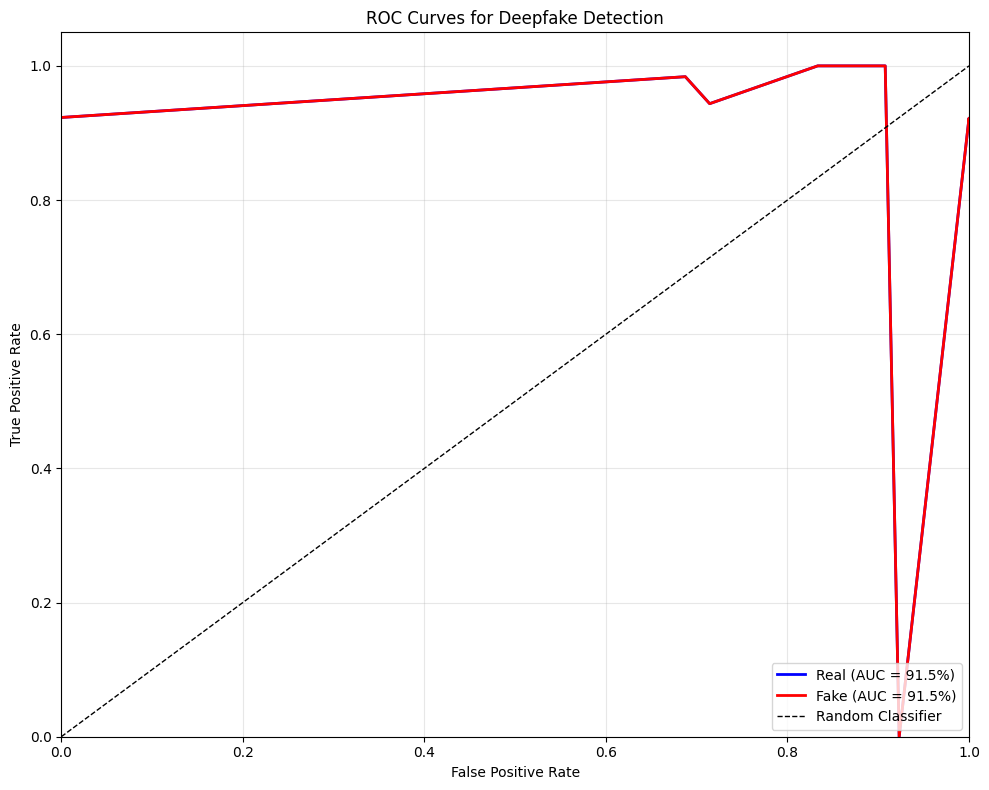

Classification Epoch 6/30: 100%|██████████| 3/3 [00:00<00:00, 16.77it/s, Loss=0.2782, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 6 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 96.74%
    ROC-AUC: 90.19%
    Equal Error Rate: 3.85%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 96.74%
    ROC-AUC: 90.19%
    Equal Error Rate: 3.85%


Classification Epoch 7/30: 100%|██████████| 3/3 [00:00<00:00, 16.90it/s, Loss=0.2286, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 7 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 97.03%
    ROC-AUC: 85.23%
    Equal Error Rate: 3.85%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 97.03%
    ROC-AUC: 85.23%
    Equal Error Rate: 3.85%


Classification Epoch 8/30: 100%|██████████| 3/3 [00:00<00:00, 16.76it/s, Loss=0.2551, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 8 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 96.33%
    ROC-AUC: 86.77%
    Equal Error Rate: 3.25%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 96.33%
    ROC-AUC: 87.07%
    Equal Error Rate: 3.25%


Classification Epoch 9/30: 100%|██████████| 3/3 [00:00<00:00, 16.45it/s, Loss=0.2348, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 9 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.96%
    ROC-AUC: 88.07%
    Equal Error Rate: 3.25%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.96%
    ROC-AUC: 88.37%
    Equal Error Rate: 3.25%


Classification Epoch 10/30: 100%|██████████| 3/3 [00:00<00:00, 16.62it/s, Loss=0.2263, Acc=0.9286, LR=1.00e-04]



 Detailed Epoch 10 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 93.17%
    ROC-AUC: 88.60%
    Equal Error Rate: 3.25%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 93.17%
    ROC-AUC: 88.80%
    Equal Error Rate: 3.25%


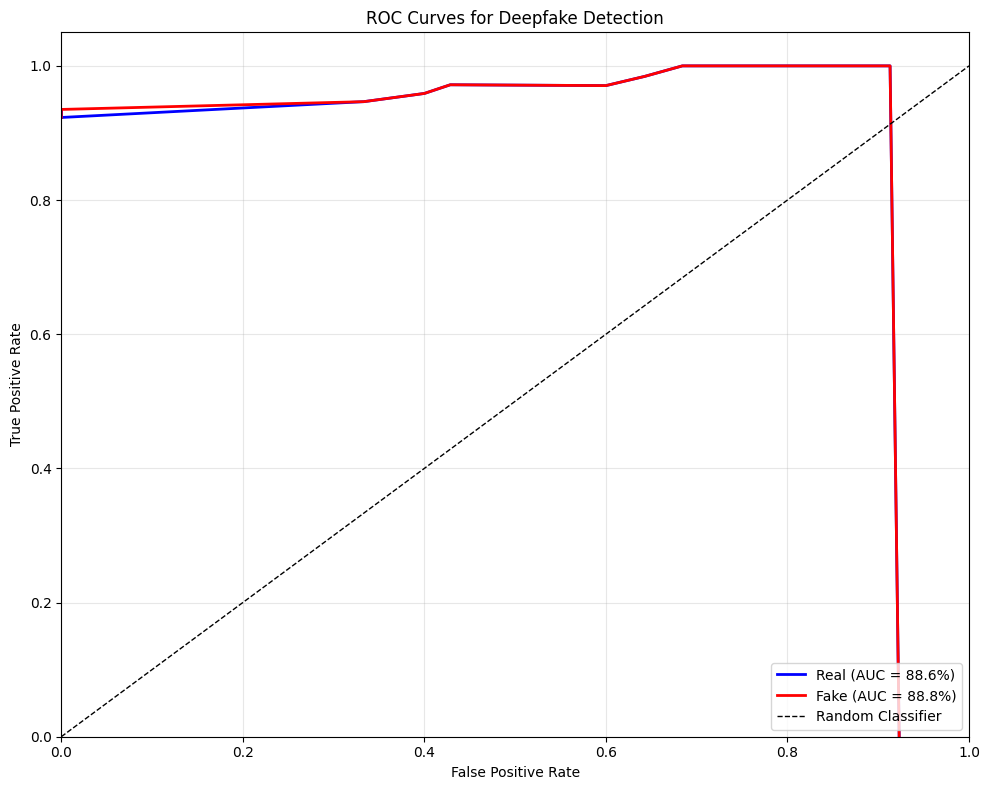

Classification Epoch 11/30: 100%|██████████| 3/3 [00:00<00:00, 16.82it/s, Loss=0.1789, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 11 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 92.24%
    ROC-AUC: 88.79%
    Equal Error Rate: 3.25%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 92.24%
    ROC-AUC: 88.99%
    Equal Error Rate: 3.25%


Classification Epoch 12/30: 100%|██████████| 3/3 [00:00<00:00, 16.96it/s, Loss=0.2002, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 12 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 91.93%
    ROC-AUC: 89.14%
    Equal Error Rate: 2.63%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 91.93%
    ROC-AUC: 89.55%
    Equal Error Rate: 2.63%


Classification Epoch 13/30: 100%|██████████| 3/3 [00:00<00:00, 17.07it/s, Loss=0.2344, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 13 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 92.07%
    ROC-AUC: 88.60%
    Equal Error Rate: 2.63%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 92.07%
    ROC-AUC: 89.00%
    Equal Error Rate: 2.63%


Classification Epoch 14/30: 100%|██████████| 3/3 [00:00<00:00, 15.95it/s, Loss=0.1914, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 14 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 92.74%
    ROC-AUC: 89.31%
    Equal Error Rate: 2.63%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 92.74%
    ROC-AUC: 89.72%
    Equal Error Rate: 2.63%


Classification Epoch 15/30: 100%|██████████| 3/3 [00:00<00:00, 16.56it/s, Loss=0.1785, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 15 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 93.32%
    ROC-AUC: 88.85%
    Equal Error Rate: 2.63%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 93.32%
    ROC-AUC: 89.25%
    Equal Error Rate: 2.63%


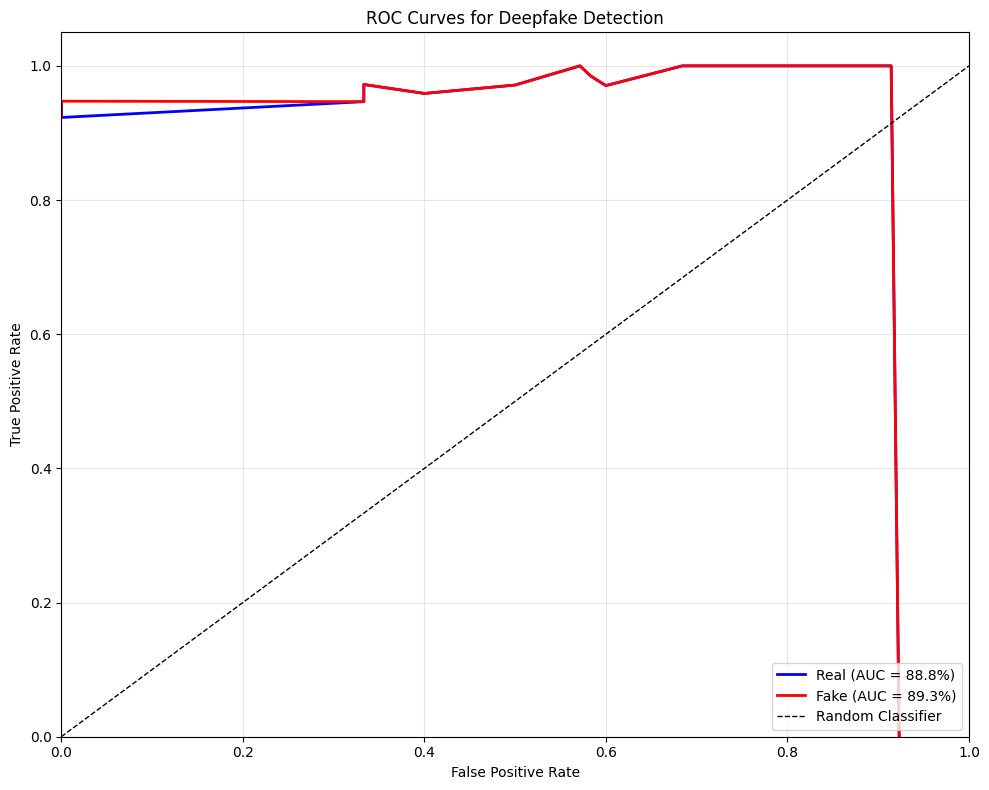

Classification Epoch 16/30: 100%|██████████| 3/3 [00:00<00:00, 16.42it/s, Loss=0.1672, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 16 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 93.92%
    ROC-AUC: 89.16%
    Equal Error Rate: 2.63%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 93.92%
    ROC-AUC: 89.57%
    Equal Error Rate: 2.63%


Classification Epoch 17/30: 100%|██████████| 3/3 [00:00<00:00, 16.50it/s, Loss=0.1886, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 17 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.24%
    ROC-AUC: 89.82%
    Equal Error Rate: 2.63%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.24%
    ROC-AUC: 90.22%
    Equal Error Rate: 2.63%


Classification Epoch 18/30: 100%|██████████| 3/3 [00:00<00:00, 16.79it/s, Loss=0.1661, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 18 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.40%
    ROC-AUC: 90.11%
    Equal Error Rate: 2.63%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.40%
    ROC-AUC: 90.35%
    Equal Error Rate: 2.63%


Classification Epoch 19/30: 100%|██████████| 3/3 [00:00<00:00, 16.84it/s, Loss=0.1734, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 19 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.54%
    ROC-AUC: 89.78%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.54%
    ROC-AUC: 90.61%
    Equal Error Rate: 1.35%


Classification Epoch 20/30: 100%|██████████| 3/3 [00:00<00:00, 16.89it/s, Loss=0.1621, Acc=0.9286, LR=5.00e-05]



 Detailed Epoch 20 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.53%
    ROC-AUC: 89.92%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.53%
    ROC-AUC: 90.75%
    Equal Error Rate: 1.35%


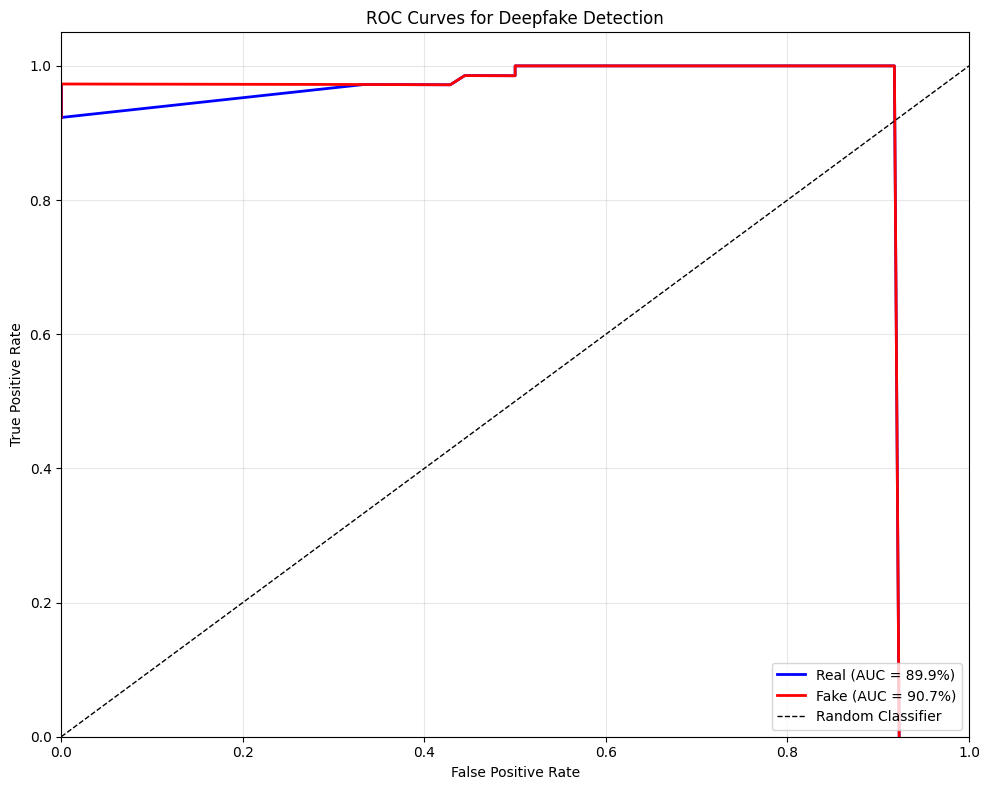

Classification Epoch 21/30: 100%|██████████| 3/3 [00:00<00:00, 16.80it/s, Loss=0.1406, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 21 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.60%
    ROC-AUC: 89.91%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.60%
    ROC-AUC: 90.74%
    Equal Error Rate: 1.35%


Classification Epoch 22/30: 100%|██████████| 3/3 [00:00<00:00, 16.69it/s, Loss=0.1364, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 22 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.76%
    ROC-AUC: 89.73%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.76%
    ROC-AUC: 90.56%
    Equal Error Rate: 1.35%


Classification Epoch 23/30: 100%|██████████| 3/3 [00:00<00:00, 16.28it/s, Loss=0.1377, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 23 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.76%
    ROC-AUC: 89.73%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.76%
    ROC-AUC: 90.56%
    Equal Error Rate: 1.35%


Classification Epoch 24/30: 100%|██████████| 3/3 [00:00<00:00, 15.93it/s, Loss=0.1318, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 24 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.83%
    ROC-AUC: 89.75%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.83%
    ROC-AUC: 90.59%
    Equal Error Rate: 1.35%


Classification Epoch 25/30: 100%|██████████| 3/3 [00:00<00:00, 16.95it/s, Loss=0.1355, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 25 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.89%
    ROC-AUC: 89.69%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.89%
    ROC-AUC: 90.52%
    Equal Error Rate: 1.35%


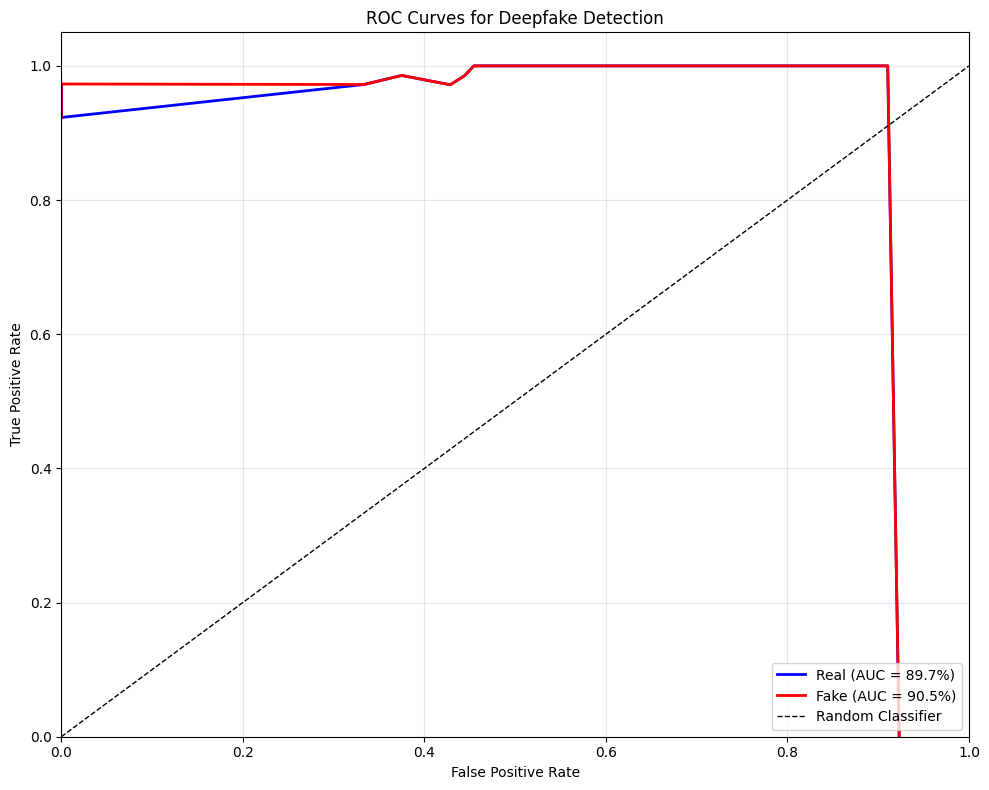

Classification Epoch 26/30: 100%|██████████| 3/3 [00:00<00:00, 15.78it/s, Loss=0.1266, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 26 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.99%
    ROC-AUC: 90.02%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 94.99%
    ROC-AUC: 90.51%
    Equal Error Rate: 1.35%


Classification Epoch 27/30: 100%|██████████| 3/3 [00:00<00:00, 16.07it/s, Loss=0.1338, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 27 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 95.11%
    ROC-AUC: 89.95%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 95.11%
    ROC-AUC: 90.45%
    Equal Error Rate: 1.35%


Classification Epoch 28/30: 100%|██████████| 3/3 [00:00<00:00, 16.16it/s, Loss=0.1003, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 28 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 95.22%
    ROC-AUC: 89.86%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 95.22%
    ROC-AUC: 90.36%
    Equal Error Rate: 1.35%


Classification Epoch 29/30: 100%|██████████| 3/3 [00:00<00:00, 16.52it/s, Loss=0.1145, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 29 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 95.42%
    ROC-AUC: 89.74%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 95.42%
    ROC-AUC: 90.24%
    Equal Error Rate: 1.35%


Classification Epoch 30/30: 100%|██████████| 3/3 [00:00<00:00, 15.48it/s, Loss=0.1020, Acc=0.9286, LR=2.50e-05]



 Detailed Epoch 30 Evaluation:

 Metrics for Real (Class 0):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 95.58%
    ROC-AUC: 89.61%
    Equal Error Rate: 1.35%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 95.58%
    ROC-AUC: 90.11%
    Equal Error Rate: 1.35%


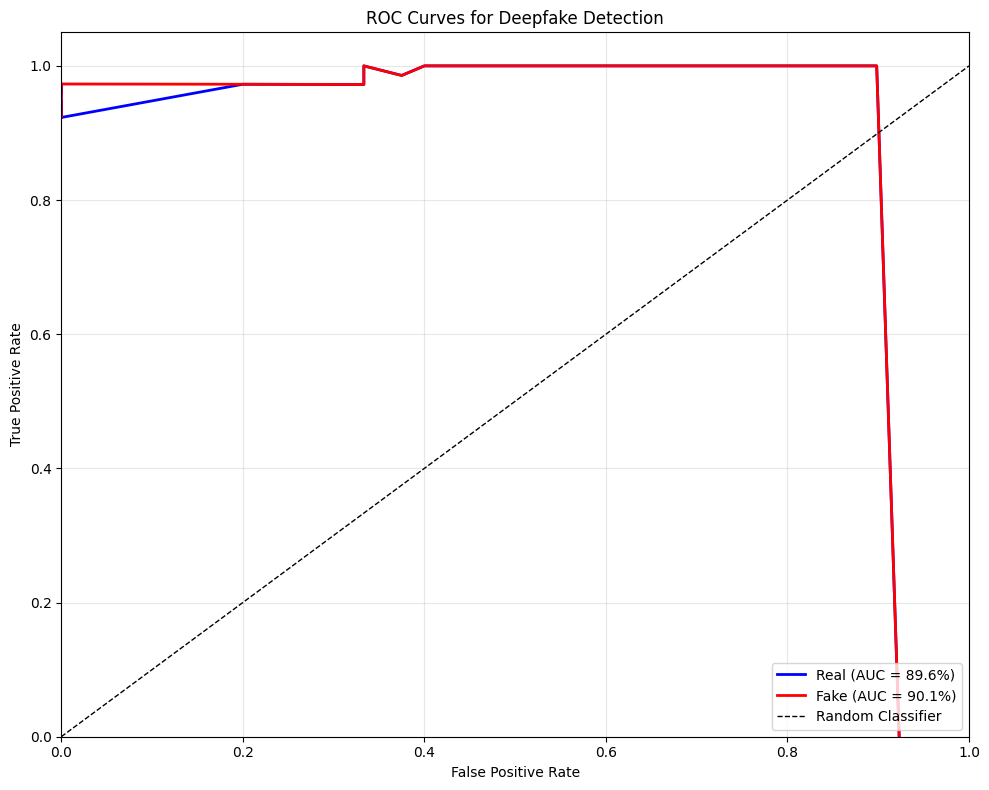

Best Fake Detection F1: 96.00%


In [21]:
classifier = train_classification(a2v, v2a, num_epochs=30)

In [22]:
def eval(a2v, v2a, model_path='best.pt', test_loader=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if test_loader is None:
        test_loader = loader  # Use your existing loader
    
    # Load classifier
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    classifier = DeepfakeClassifier().to(device)
    classifier.load_state_dict(checkpoint['classifier'])
    classifier.eval()
    
    # Use your existing networks
    a2v.eval()
    v2a.eval()
    
    print(" Using existing A2V/V2A networks for evaluation")
    
    # Evaluation with comprehensive metrics
    all_preds = []
    all_labels = []
    all_logits = []
    
    with torch.no_grad():
        for v, a, vm, am, labels in tqdm(test_loader, desc="Evaluating"):
            v = v.float().to(device)
            a = a.float().to(device)
            
            # Generate cross-modal features
            fa_list, fv_list = [], []
            for b in range(v.size(0)):
                a_all, v_all = a[b], v[b]
                a_v, v_a = v2a(v_all), a2v(a_all)
                fa = torch.cat([a_all, a_v], dim=-1)
                fv = torch.cat([v_all, v_a], dim=-1)
                fa_list.append(fa)
                fv_list.append(fv)
            
            fa_batch = torch.stack(fa_list)
            fv_batch = torch.stack(fv_list)
            
            # Prediction
            logits = classifier(fa_batch, fv_batch)
            pred = logits.argmax(dim=-1)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_logits.extend(logits.cpu().numpy())
    
    # Convert to probabilities
    all_probs = torch.softmax(torch.tensor(all_logits), dim=-1).numpy()
    
    print(f"\n Final Test Results:")
    print("=" * 50)
    
    # Comprehensive evaluation using your custom metrics
    final_metrics = metrics(all_labels, all_probs)
    
    # Plot final ROC curves
    plot_roc_curves(all_labels, all_probs, 'final_test_roc.png')
    
    # Additional analysis
    print(f"\n Key Performance Indicators:")
    print(f"    Best Threshold EER: {final_metrics['fake_eer']:.2f}%")
    print(f"    Fake Detection F1: {final_metrics['fake_f1']:.2f}%")
    print(f"    Real Detection F1: {final_metrics['real_f1']:.2f}%")
    
    return final_metrics

 Using existing A2V/V2A networks for evaluation


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


 Final Test Results:

 Metrics for Real (Class 0):


    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 58.01%
    ROC-AUC: 85.82%
    Equal Error Rate: 3.85%

 Metrics for Fake (Class 1):
    Accuracy: 92.31%
    Precision: 100.00%
    Recall: 92.31%
    F1-Score: 96.00%
    Average Precision: 58.01%
    ROC-AUC: 85.82%
    Equal Error Rate: 3.85%


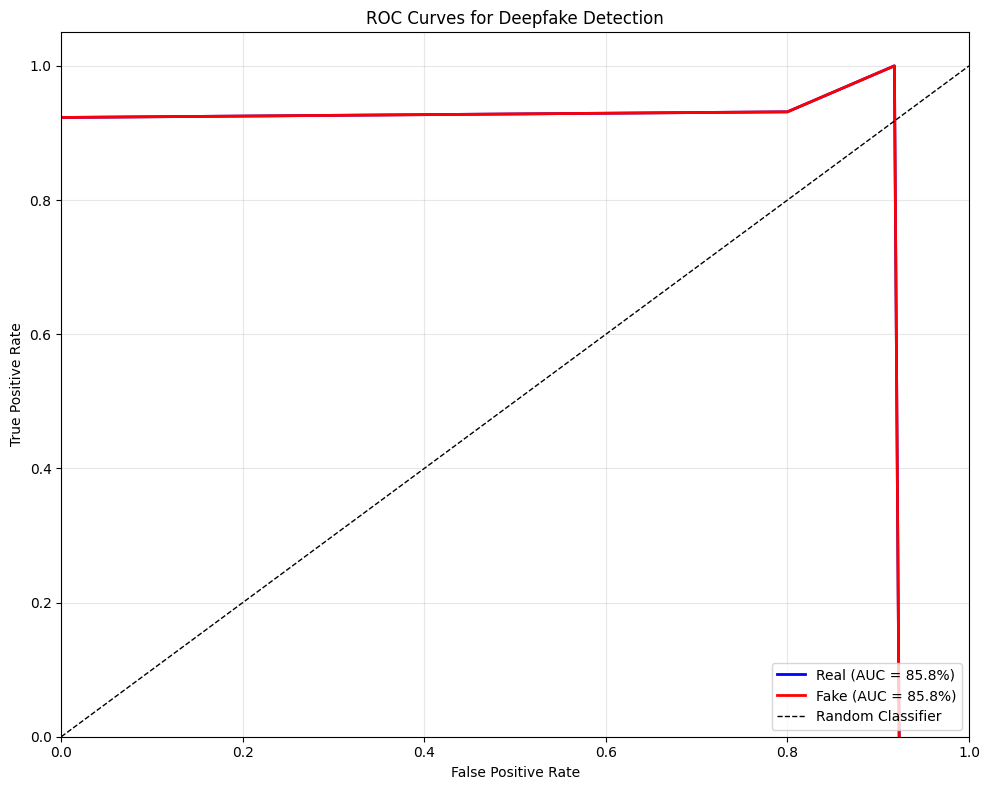


 Key Performance Indicators:
    Best Threshold EER: 3.85%
    Fake Detection F1: 96.00%
    Real Detection F1: 96.00%


In [23]:
results = eval(a2v, v2a, 'best.pt')